<a href="https://colab.research.google.com/github/audrb1999/Paper_review/blob/main/08.DeepSpeed_and_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Deepspeed

- Transformer

## DeepSpeed 추가 학습 내용 정리

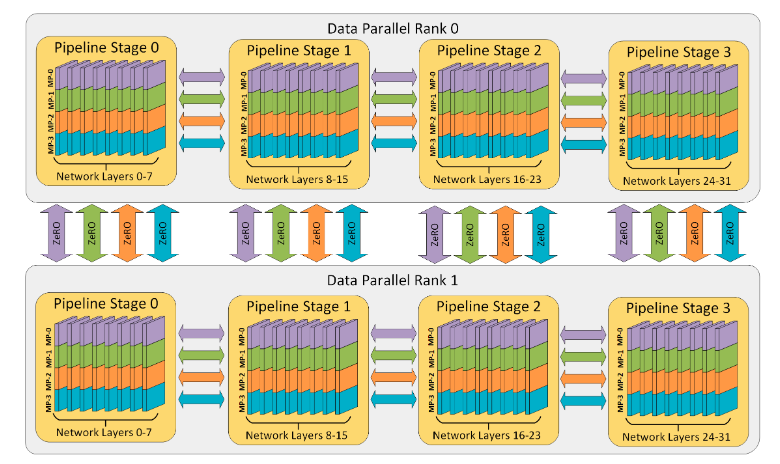

3D parallelism 사진

- Data Parallel rank = 데이터 병렬 처리된 그룹을 의미 (zero 기반 데이터 병렬 처리)
- 그 다음 마이크로 배치로 파이프라인 병렬 처리 (zero를 사용하여 필요한 레이어를 받아온다는 것)

- 2개의 데이터  병렬처리와 신경망을 4개의 파이프라인 스테이지로 나눈 것 그 다음 각 파이프라인 스테이지 내에서 4개의 모델 병렬 처리가 된 것

- 데이터 병렬 사이 제로는 optimizer state를 주고 받는 다는 것

병렬처리는 학습때만 적용하고 추론때는 잘 사용을 하지 않음

- 병렬 처리를 어떻게 사용해야 잘 사용하는지 알아보기
- 어떤 상황에서 사용하는지, 병렬처리를 적용했을 때 생기는
  - https://huggingface.co/docs/transformers/v4.15.0/parallelism

- 메가트론 lm(학습), fater transformer(추론) = GPU 사용량이 많음
 - 구조가 어떻게 생겼는지 이해해보기


### PP와 ZeRO의 차이


1. 파이프라인은 주로 레이어 단위로 나누고 zero는 레이어 단위 보다 더 작게(파라미터의 열 단위)로 나눌 수 있음
2. zero는 메모리 활용도가 높다
3. communication volume 차이

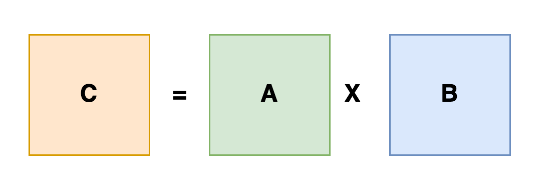

한 레이어에 다음과 같은 연산이 존재한다고 하면

q는 입력, b는 파라미터임

그러면 파이프라인은 레이어 단위로 나누면 $A \times B$ 형태로 나눈다면

ZeRO는 파라미터 매트릭스를 쪼개 $A \times $$\begin{bmatrix}B_1\\B_2\\ : \\ B_n \end{bmatrix}$ 다음과 같이 행 단위로 사용할 수 있따.

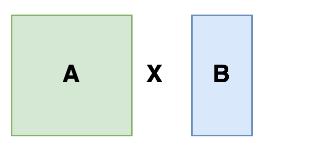

그리고 이렇게 파라미터를 쪼개서 보관하니 파이프라인보다 메모리 효율이 좋다

## Transformer

기존 seq2seq에 문제가 존재했는데

1. 입력 시퀀스를 context 벡터라는 하나의 고정된 크기 벡터로 압축하면 정보손실이 생긴다는 점
2. RNN의 기울기 소실 문제

1번쨰 문제로 인해 입력 길이가 길어지면 번역 품질이 떨어지는 현상이 발생

이걸 방지하기 위해 어텐션이라는 기법을 소개


어텐션은 매 시점(time step)마다 인코더에서의 전체 입력 문장을 한 번 더 참고하는 점입니다. (기울기 소실을 해결하기 위한 방법 cnn에서는 resnet 비슷하게 생각할 수 잇음)

- 단 동일한 비율로 입력 문장을 참고하는 것이 아니라 해당 시점에서 예측해야할 단어와 연관이 있는 단어 부분의 비중을 더 높여서 확인



트랜스포머는 RNN을 사용하지 않지만 seq2seq 처럼 인코더에서 입력 시퀀스를 받고 디코더에서 출력 시퀀스를 출력하는 구조

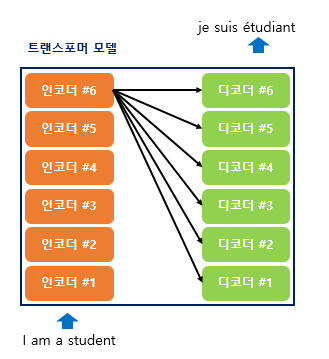



RNN은 순차적으로 입력을 받아 단어의 위치 정보를 알아냈음 이 때문에 병렬처리가 불가능했다.

하지만 트랜스포머에서는 입력을 순차적으로 받지 않기 때문에 단어 위치를 알려주는 방법이 필요함

- 각 단어의 임베딩 벡터에 위치 정보들을 더해서 입력으로 사용하는 포지셔널 인코딩을 사용

### 핵심 아이디어

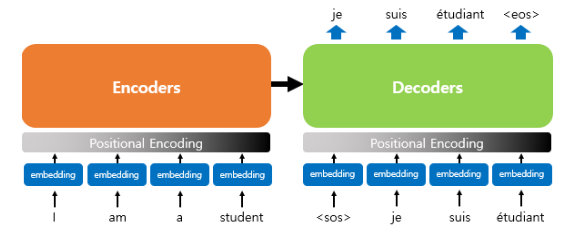

다음과 같이 입력으로 단어를 넣어주기 전에 포지셔널 인코딩 값을 더해서 진행함 시각화하자면

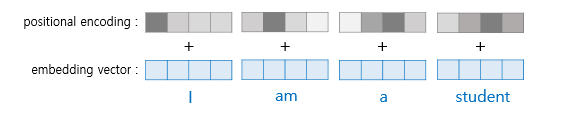

포지셔널 인코딩은 트랜스포머의 위치 정보를 가진 값을 만들기 위해 아래 두 함수를 사용

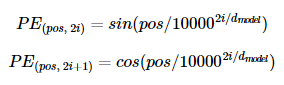

사인 코사인 함수를 임베딩 벡터에 더해주는 형태로 단어의 위치를 알려줌

- $pos$: 입력 문장에서의 임베딩 벡터 위치 (행)
- $i$: 임베딩 벡터 내의 차원의 인덱스 (열)
- $d_{model}$: 트랜스포머의 모든 층의 출력 차원을 의미 (하이퍼 파라미터로 우리가 설정하는 값)

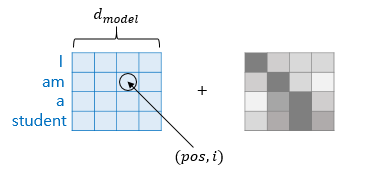


$(pos, 2i)$로 인덱스가 짝수일땐 사인  $(pos, 2i+1)$로 인덱스가 홀수일땐 코사인을 사용

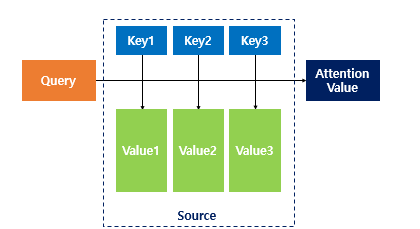

Querey : 분석이 대상이 되는 단어에 대한 가중치 벡터

Key : 모든 단어. 각 단어가 쿼리에 해당하는 단어가 얼마나 연관이 있는가

value : 키의 의미를 나타내는 가중치 벡터


- 인코더에 입력된 단어들의 querey, key, value 벡터들을 concat하여 matrix를 만듭니다.

그리고 어텐션 함수를 통해 쿼리에 대해서 모든 키와 유사도를 각각 구합니다.

구해낸 유사도를 가중치로 설정하고 키와 매핑된 각각의 벨류를 반영해줍니다.

- 그 다음 유사도가 반영된 값을 모두 가중합하여 리턴합니다.

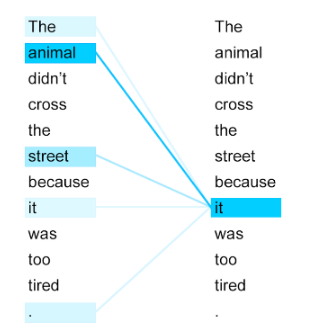

"그 동물은 길을 건너지 않았다, 그것은 너무 피곤했기 때문이다."

이 문장에서 그것(it)이 동물을 의미하는지 길을 의미하는지 정확하게 알아야 문장을 이해한다고 할 수 있습니다.

- self attention을 통해 입력 문장 내에 각 단어의 유사도를 구함으로써 it이 의미하는 것이 animal과 연관된 확률이 높다는 것을 알아낸 것입니다.

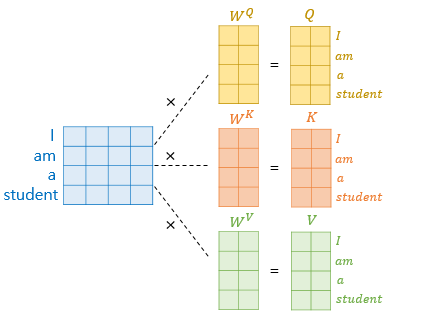

다음과 같이 각 단어에 대한 가중치 행렬을 구하고 전체 문장 행렬에 가중치 행렬을 곱해 Q, K, V 행렬을 구합니다.

그 이후

$$Attention(Q, K, V) = softmax(\frac {QK^T}{\sqrt{d_k}})V$$

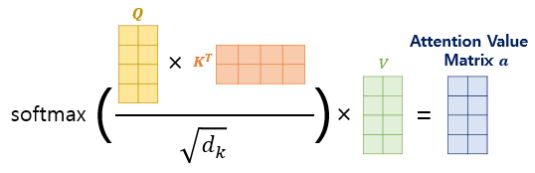

위 수식을 통해 각 단어들이 어떤 관계를 갖고 있는지 수치화 합니다.

#### multi head attention

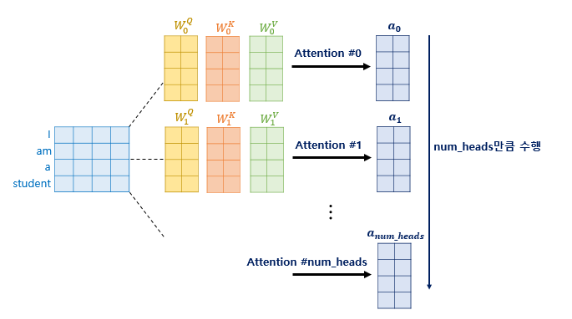

한 번 어텐션을 진행하는 것보다 여러번의 어텐션을 병렬로 사용하는 것이 효과적이라고 판단했기 때문에

num_heads라는 하이퍼 파라미터 값을 설정해서 여러번 진행합니다.

- 서로 다른 attention(head)를 통해서 문장 내의 서로 다른 관계를 배울 수 있습니다.
- 직관적으로 본다면 여러 시점에서 각 단어의 유사도를 본다고 생각할 수 있습니다.

8개의 head를 사용해서 구한다면 한 단어와 유사도가 높은 하나의 단어에 대한 수치를 구하는 것이 아닌 유사도가 높은 8개의 단어와 연관도를 구하는 것입니다.

- ex) 한 고양이 사진에 대해서 소, 강아지, 고양이 와 같이 3개의 레이블로 분류를 진행할 때 단순히 입력 이미지가 고양이 연관성이 가장 높다 것을 구하는 것이 아니라 다른 2개의 레이블과의 연관성도 구하여 소보다 강아지에 가까운 형상이라는 정보를 얻어내는 방법

- 이 방법을 사용할 경우 데이터에 대한 확률 분포를 얻을 때 조금 더 부드러운 확률 분포를 얻을 수 있습니다.

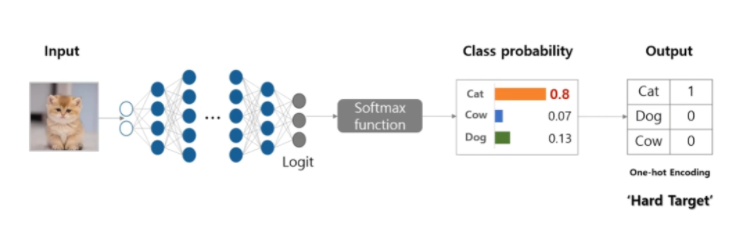

one - hot encoding을 통해서 가장 높은 것만 1 나머지를 0으로 설정하면 확률분포가 부드럽게 나오지 않습니다.

- 어떻게 보면 정보의 손실이 발생한다 라고 생각이 가능

### Residual connection과 layer normalization

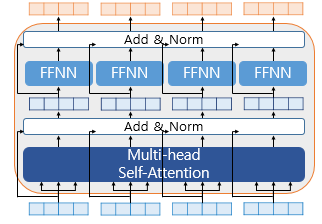

residual connection은 서브층의 입력과 출력을 더한 것을 의미합니다.

컴퓨터 비전에서 주로 사용하는 방법으로 모델이 깊어질 때 기울기 문제를 해결하는 방법으로 쓰입니다.



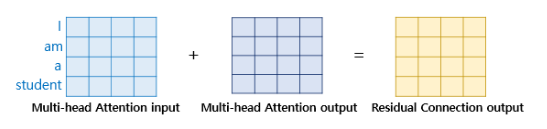

서브층이 멀티 헤드 어텐션이라면 위와 같이 진행됩니다.



layer normalization은 residual connection 이후에 대해서 평균과 분산을 구해 정규화 해주는 방식입니다.

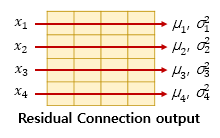

평균 $\mu$, 분산 $\sigma^2$를 구해서

각 원소에 대해


$$\hat{x} = \frac{x - \mu} {\sqrt{\sigma^2 + ϵ}}$$

그 다음 $\gamma, \beta$ 벡터 다음과 같이 수식과 연결해줍니다.

- 감마의 초기값은 1, 벡터의 초기값은 0이며 이 파라미터들도 학습을 반복하면서 값이 바뀌게 됩니다.

$$\gamma \hat{x} + \beta$$

Batch normalization과 유사